# Notes

* Look's like I'm going to have to re-make the color-mag data and re-apply cuts for it. 
    * For color-mag demo see ```efforts\eta\imp_funcs\prep_695_data.py```
    * For cuts information see ```efforts\iota\final_sample\applying_cuts.py```

In [3]:
import matplotlib.pyplot as plt  
import numpy as np 
import pandas as pd
from scipy.interpolate import interp1d, NearestNDInterpolator, LinearNDInterpolator
import uncertainties as unc  
import uncertainties.unumpy as unumpy  

In [4]:
g_df = pd.read_csv('https://raw.githubusercontent.com/HarritonResearchLab/NAPYSOs/main/recovered/LAH2.0/data/AUGUST_5th/light_curves/2MASS_J20470481%2B4349114_g.csv')
r_df = pd.read_csv('https://raw.githubusercontent.com/HarritonResearchLab/NAPYSOs/main/recovered/LAH2.0/data/AUGUST_5th/light_curves/2MASS_J20470481%2B4349114_r.csv')

g_mjds = np.array(g_df['mjd'])
g_mags = np.array(g_df['mag'])
g_magerrs = np.array(g_df['magerr'])

r_mjds = np.array(r_df['mjd'])
r_mags = np.array(r_df['mag'])
r_magerrs = np.array(r_df['magerr'])

g_combined = unumpy.uarray((g_mags, g_magerrs))  
r_combined = unumpy.uarray((r_mags, r_magerrs))

C:\Users\Research\AppData\Local\Temp/ipykernel_17696/457217523.py:12: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
  g_combined = unumpy.uarray((g_mags, g_magerrs))
C:\Users\Research\AppData\Local\Temp/ipykernel_17696/457217523.py:13: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
  r_combined = unumpy.uarray((r_mags, r_magerrs))


In [5]:
print((r_combined[0:169]-g_combined)[0:4])

[-1.2440491000000016+/-0.11256479568127054
 -0.9892177000000011+/-0.10033238028807676
 -1.1235599999999977+/-0.10991144874262049
 -1.6687984999999976+/-0.15748883354064988]


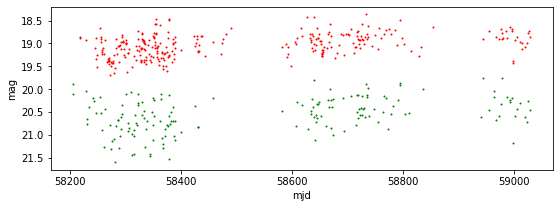

In [6]:
fig, ax = plt.subplots(figsize=(9,3))

ax.scatter(g_mjds, g_mags, color='green',s=1)
ax.scatter(r_mjds, r_mags, color='red',s=1)

ax.set(xlabel='mjd',ylabel='mag')
ax.invert_yaxis()

plt.show()


In [7]:
r_idx_to_remove = np.logical_or(r_mjds>np.max(g_mjds), r_mjds<np.min(g_mjds))
r_mjds, r_mags, r_magerrs = (np.delete(arr,r_idx_to_remove) for arr in [r_mjds, r_mags, r_magerrs])

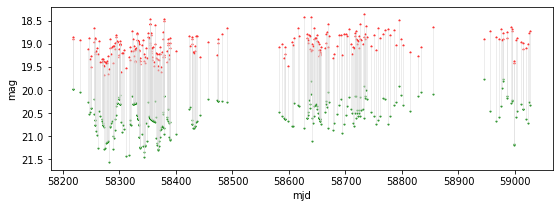

In [8]:
interp = interp1d(g_mjds, g_mags,bounds_error=False, fill_value=np.nan)
interpolated_g = interp(r_mjds)

fig, ax = plt.subplots(figsize=(9,3))

ax.vlines(r_mjds, r_mags, interpolated_g, colors=len(r_mjds)*['gainsboro'], lw=0.5)
ax.scatter(r_mjds, interpolated_g,color='green',s=1)
ax.scatter(r_mjds, r_mags,color='red',s=1)

ax.set(xlabel='mjd',ylabel='mag')
ax.invert_yaxis()

plt.show()

In [9]:
print(min(g_mjds), max(g_mjds))
print(min(r_mjds), max(r_mjds))

58206.4825463 59028.3961921
58218.4943056 59026.4810995


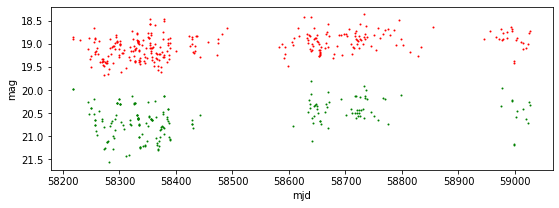

In [10]:
### BRUH. Did I just turn 100s of lines of code from the old interpolation routine into ~10? AHHAHAHAHAHAHA

indices_to_drop = np.array([]).astype(int)

for r_index, r_mjd in enumerate(r_mjds): 
    diffs = g_mjds - r_mjd
    lowers = diffs[np.where(diffs<0)] 
    uppers = diffs[np.where(diffs>0)] 
    
    if len(lowers) == 0: 
        lower = 0
    
    else: 
        lower = np.max(lowers)
    
    if len(uppers) == 0: 
        upper = 0
    
    else: 
        upper = np.min(uppers)

    window = np.abs(upper+lower)  

    if window >= 3: 
        indices_to_drop = np.append(indices_to_drop, r_index)

g_interp_mjds, g_interp_mags = (np.delete(arr, indices_to_drop) for arr in [r_mjds, interpolated_g])

fig, ax = plt.subplots(figsize=(9,3))

ax.scatter(g_interp_mjds, g_interp_mags, color='green', s=1)
ax.scatter(r_mjds, r_mags, color='red', s=1)

ax.set(xlabel='mjd',ylabel='mag')
ax.invert_yaxis()

plt.show()


### uncertainties package redux

In [11]:
import uncertainties as u
from uncertainties.umath import * 
from uncertainties import unumpy


In [14]:
g_u = unumpy.uarray(g_mags, g_magerrs)
r_u = unumpy.uarray(r_mags, r_magerrs)
r_mjds_u = unumpy.uarray(r_mjds, np.zeros(shape=r_mjds.shape))
g_mjds_u = unumpy.uarray(g_mjds, np.zeros(shape=g_mjds.shape))

#interp = u.wrap(interp1d(g_mjds_u, g_u,bounds_error=False, fill_value=np.nan))

interp = u.wrap(interp1d)(g_mjds_u, g_u,bounds_error=False, fill_value=np.nan)

# example: u.wrap(np.exp)(u.ufloat(x, xerr))

interpolated_g = interp(r_mjds_u)

TypeError: can't convert an affine function (<class 'uncertainties.core.Variable'>) to float; use x.nominal_value

### interpolate from scratch
* so I can use uncertainties
* *To account for propogation of errors we wrote a custom linear interpolation routine which utilized the Python ```uncertainties``` package.* ... or something

In [15]:
def interpolate(x, x1, y1, x2, y2): 
    m = (y2-y1)/(x2-x1)
    b = y1-m*x1
    return x*m+b

In [17]:
x = u.ufloat(3,0.2)
x1 = u.ufloat(1, 0.23)
y1 = u.ufloat(1,0.14)
x2 = u.ufloat(5, 0.12)
y2 = u.ufloat(5.1, 0.14)

print(interpolate(x,x1,y1, x2, y2))

3.05+/-0.26


In [60]:
interpolated_gs_u = np.array([])
interpolated_mags = np.array([])
interpolated_dates = np.array([])
r_mags_u = np.array([])
interpolated_errors = np.array([])

for r_index, r_mjd in enumerate(r_mjds): 
    diffs = g_mjds - r_mjd
    lowers = diffs[np.where(diffs<0)] 
    uppers = diffs[np.where(diffs>0)] 
    
    if len(lowers) == 0: 
        lower = 0
    
    else: 
        lower = np.max(lowers)
    
    if len(uppers) == 0: 
        upper = 0
    
    else: 
        upper = np.min(uppers)

    window = np.abs(upper+lower)  

    if window < 3:
        if lower+upper == 0: 
            print(lower, upper)
        
        lower_index = np.where(diffs==lower)
        upper_index = np.where(diffs==upper)

        r_mjd_u = u.ufloat(r_mjd, 0)
        g_mjd_1 = u.ufloat(g_mjds[lower_index], 0)
        g_mag_1 = u.ufloat(g_mags[lower_index], g_magerrs[lower_index])
        g_mjd_2 = u.ufloat(g_mjds[upper_index], 0)
        g_mag_2 = u.ufloat(g_mags[upper_index], g_magerrs[upper_index])
        

        interpolated = interpolate(r_mjd_u, g_mjd_1, g_mag_1, g_mjd_2, g_mag_2)
        interpolated_gs_u = np.append(interpolated_gs_u, interpolated)
        str_g = str(interpolated).split('+/-')
        str_g_mag = str_g[0]
        str_g_magerr = str_g[1]
        interpolated_mags = np.append(interpolated_mags, float(str_g_mag))
        interpolated_dates = np.append(interpolated_dates, r_mjd)
        r_mag_u = u.ufloat(r_mags[r_index], r_magerrs[r_index])
        r_mags_u = np.append(r_mags_u, r_mag_u)
        interpolated_errors = np.append(interpolated_errors, float(str_g_magerr))

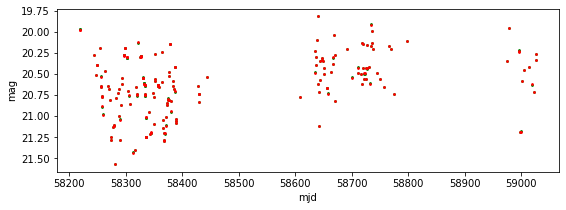

In [38]:
## Quick quality check


fig, ax = plt.subplots(figsize=(9,3))

ax.scatter(g_interp_mjds, g_interp_mags, color='green', s=3)
ax.scatter(interpolated_dates, interpolated_mags, color='red', s=3)

ax.set(xlabel='mjd',ylabel='mag')
ax.invert_yaxis()

plt.show()

In [44]:
colors_u = interpolated_gs_u-r_mags_u


colors = np.array([])
color_errors = np.array([])

for color_u in colors_u: 
    string_list = str(color_u).split('+/-')
    colors = np.append(colors, float(string_list[0]))
    color_errors = np.append(color_errors, float(string_list[1]))

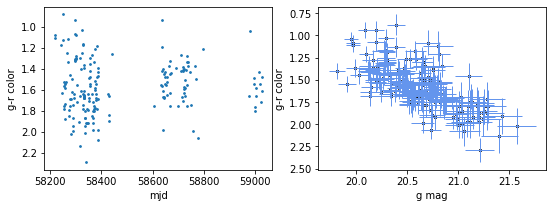

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(9,3))

axs[0].scatter(interpolated_dates, colors, s=3)

axs[0].set(xlabel='mjd',ylabel='g-r color')
axs[0].invert_yaxis()

axs[1].errorbar(interpolated_mags, colors, xerr = interpolated_errors, yerr=color_errors, lw=0, elinewidth=1, ecolor='cornflowerblue')
axs[1].scatter(interpolated_mags, colors, color='cornflowerblue', edgecolor='black', s=5)
axs[1].invert_yaxis()
axs[1].set(xlabel='g mag', ylabel='g-r color')

plt.show()